In [1]:
'''
created on June 6th 2022 @ 3rd Eddy Cross Disciplinary Symposium, Vail, CO, USA
Code based on original idea by Dan Marsh (NCAR, University of Leeds)
Authors:
Gregory Cooke (University of Leeds, pygjc@leeds.ac.uk)
Allison Youngblood (NASA Goddard)
Caitlin Gough (University of Leeds)
James Colliander (University of Leeds)
'''

'''
USER GUIDE
Code to read in files from the MUSCLES database
and scale them to be used in various atmospheric models
for different planets in those stellar systems

Run each cell until drop down menus appear
Select your desired options from dropdown menus
'''

'''
To do list
rebin spectra
save out spectra file
add different climate model wavelength grids (only WACCM, ROCKE-3D so far)
comment code better
'''

#imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipywidgets import interactive
import matplotlib.gridspec as gridspec
from astropy.io import fits

In [2]:
# return subscript number or text as a string
def sub(Input):
    return r'$_{'+str(Input)+'}$'

# return superscript number or text as a string
def sup(Input):
    return r'$^{'+str(Input)+'}$'

In [231]:
#MUSCLES data type selection

#get a drop down menu
import ipywidgets as widgets
Data_Type_List = ['Constant native resolution','Variable native resolution','Constant adaptive resolution','Variable adaptive resolution']

#select data type from MUSCLES files
data_type = widgets.Dropdown(options=(Data_Type_List),description='Data type selection',disabled=False)
display(data_type)

Dropdown(description='Data type selection', options=('Constant native resolution', 'Variable native resolution…

In [263]:
'''
program options begin here
List of MUSCLES database below
'''

#reads in json files for MUSCLES data 
import json

if (data_type.value == 'Constant adaptive resolution'): 
    stellar_names_const_adapt_json = open('stellar_names_const_adapt.json')
    sstellar_names_and_data = json.load(stellar_names_const_adapt_json)
elif (data_type.value == 'Constant native resolution'): 
    stellar_names_const_native_json = open('stellar_names_const_native.json')
    stellar_names_and_data= json.load(stellar_names_const_native_json)
elif (data_type.value == 'Variable adaptive resolution'): 
    stellar_names_var_adapt_json = open('stellar_names_var_adapt.json')
    stellar_names_and_data = json.load(stellar_names_var_adapt_json)
elif  (data_type.value == 'Variable native resolution'):
    stellar_names_var_native_json = open('stellar_names_var_native.json')
    stellar_names_and_data = json.load(stellar_names_var_native_json)

#get a drop down menu
import ipywidgets as widgets
#select directories for MUSCLES files
MUSCLES_files = widgets.Dropdown(options=(stellar_names_and_data),description='MUSCLES Files:',disabled=False)
display(MUSCLES_files)

Dropdown(description='MUSCLES Files:', options={'GJ 1132': 'https://archive.stsci.edu/missions/hlsp/muscles/gj…

In [264]:
'''
set Spectra_name_same_as_host_name = False if looking at exoplanets around
a different star to the ones in the MUSCLES database
i.e you want spectra for an M8 star but the closest spectra availiable is TRAPPIST-1
otherwise in this example you will only be able to select TRAPPIST-1 planets 
if Spectra_name_same_as_host_name = True
'''
Spectra_name_same_as_host_name = True

In [265]:
#get star name
star_name = [k for k, v in stellar_names_and_data.items() if v == MUSCLES_files.value][0]

In [267]:
# Import MUSCLES spectra
import os
if(os.path.isfile(MUSCLES_files.value)): print('File already downloaded')
else:os.system('wget '+ MUSCLES_files.value)

--2022-06-10 15:41:10--  https://archive.stsci.edu/missions/hlsp/muscles/gj1132/hlsp_muscles_multi_multi_gj1132_broadband_v23_const-res-sed.fits
Resolving archive.stsci.edu (archive.stsci.edu)... 130.167.201.60
Connecting to archive.stsci.edu (archive.stsci.edu)|130.167.201.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13538880 (13M) [allicashion/octet-stream]
Saving to: ‘hlsp_muscles_multi_multi_gj1132_broadband_v23_const-res-sed.fits.1’

     0K .......... .......... .......... .......... ..........  0%  603K 22s
    50K .......... .......... .......... .......... ..........  0% 1.15M 16s
   100K .......... .......... .......... .......... ..........  1% 1.16M 15s
   150K .......... .......... .......... .......... ..........  1% 40.0M 11s
   200K .......... .......... .......... .......... ..........  1%  134M 9s
   250K .......... .......... .......... .......... ..........  2% 1.18M 9s
   300K .......... .......... .......... .......... ..........  2

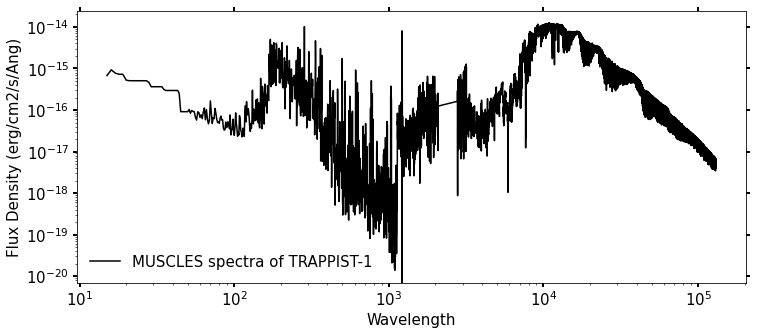

In [34]:
spec = fits.getdata(MUSCLES_files.value,1)
plt.figure(figsize = (12,5))
plt.plot(spec['WAVELENGTH'],spec['FLUX'], color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density (erg/cm2/s/Ang)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [37]:
#convert to mW/m2/nm
per_cm2_to_per_m2 = 100**2
erg_per_s_to_mW = 1e-4
per_Ang_to_per_nm = 10
New_flux = spec['FLUX'] * erg_per_s_to_mW * per_cm2_to_per_m2 * per_Ang_to_per_nm
Wavelength_nm = spec['WAVELENGTH']/10

In [38]:
# plot in new units
'''
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm,New_flux, color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)
'''

"\nplt.figure(figsize = (12,5))\nplt.plot(Wavelength_nm,New_flux, color = 'k', label = 'MUSCLES spectra of '+star_name)\nplt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)\nplt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')\nplt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')\nplt.legend(loc = 0, frameon = False, fontsize = 15)\n"

In [39]:
#remove MUSCLES files in current directory
os.system('rm *muscles*.fits')

0

In [40]:
#find total stellar irradiance from file
from scipy.integrate import trapz
#get total stellar irradiance at top of atmosphere
TSI_spectra = trapz(New_flux,Wavelength_nm)
print('Total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Total stellar irradiance relative to the Sun: 8.605194006526416e-17


In [42]:
# scale TSI
Scaled_flux_to_Earth = New_flux/(TSI_spectra/1360000)
TSI_spectra = trapz(Scaled_flux_to_Earth, Wavelength_nm)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Scaled total stellar irradiance relative to the Sun: 1.0


In [43]:
#Select climate model
Climate_model_list = ['WACCM','CAM','ExoCam','UM','ROCKE-3D','CCSM3','Atmos','ExoPrime','Custom grid']
Climate_model_selection = widgets.Dropdown(options=Climate_model_list,description='Select climate model',disabled=False)
display(Climate_model_selection)

Dropdown(description='Select climate model', options=('WACCM', 'CAM', 'ExoCam', 'UM', 'ROCKE-3D', 'CCSM3', 'At…

File already downloaded


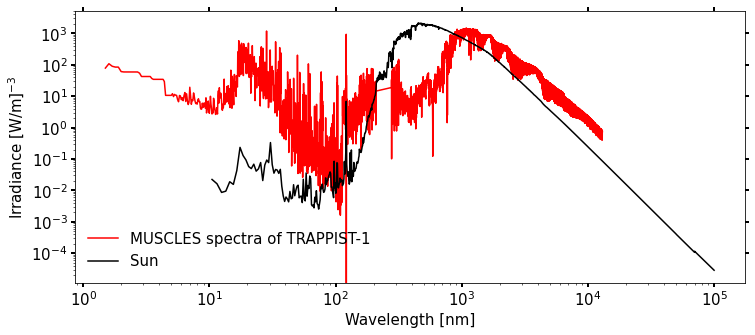

In [44]:
#Compare to WACCM standard solar file
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    #check for file. Download if not in directory
    if(os.path.isfile('SolarForcingCMIP6piControl_c160921.nc')): print('File already downloaded')
    else: os.system('wget https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc --no-check-certificate')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file

    ds = xr.open_dataset(solar_file)#attach file to dataset
    ssi = ds['ssi'].isel(time=0) #define dataset from file
    model_flux = ssi.values #flux values
    model_wavelength = ssi.wavelength.values #wavelength grid
    starlabel = 'Sun' #label for plot
    
elif(Climate_model_selection.value == 'ExoCAM'):
    print('ExoCam spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'UM'):
    print('UM spectrum input file unknown')  
    
elif(Climate_model_selection.value == 'ROCKE-3D'):
    #check for file. Download if not in directory
    if(os.path.isfile('sun')): print('File already downloaded')
    else: os.system('wget https://portal.nccs.nasa.gov/GISS_modelE/ROCKE-3D/stellar_spectra/sun')
    solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file
    ROCKE_3D_solar_input = np.genfromtxt('sun', skip_header = 5, skip_footer = 1)
    model_flux = ROCKE_3D_solar_input[:,1]
    model_wavelength =  ROCKE_3D_solar_input[:,0]*1e9 #wavelength grid
    starlabel = 'Sun' #label for plot
    
elif(Climate_model_selection.value == 'CCSM3'):
    print('CCSM3 spectrum input file unknown') 
    
elif(Climate_model_selection.value == 'Atmos'):
    if(os.path.isfile('muscles_gj667c.txt')): print('File already downloaded')
    else: os.system('wget https://raw.githubusercontent.com/VirtualPlanetaryLaboratory/atmos/master/PHOTOCHEM/DATA/FLUX/muscles_gj667c.txt')
    ATMOS_gj667c_input = np.genfromtxt('muscles_gj667c.txt')
    model_wavelength = ATMOS_gj667c_input[:,0]/10
    model_flux = ATMOS_gj667c_input[:,1]
    starlabel = 'GJ 667 C'
else:
    print('Spectrum input file unknown')
    
#compare spectra to Sun
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
plt.plot(model_wavelength, model_flux, color = 'k', label = starlabel)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Irradiance [W/m]'+sup(-3), fontsize = 15); plt.yscale('log')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [ ]:
import pandas as pd
NASA_Exo_Archive = pd.read_csv('https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv')

In [45]:
#Find planets based on host name
if (Spectra_name_same_as_host_name == True):
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == star_name]['pl_name']
    Find_planets = widgets.Dropdown(options=planets.drop_duplicates(),description='Find planets',disabled=False)
    display(Find_planets)
else:
    Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates()),description='Find host',disabled=False)
    display(Find_host)
    
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == Find_host.value]['pl_name']
    Find_planets = widgets.Dropdown(options=planets,description='Find planets',disabled=False)
    display(Find_planets)

Dropdown(description='Find planets', options=('TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 g', 'TRAPPIST-1 h', …

In [185]:
#drop nan rows for luminosity and orbital period
pl = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value].dropna(subset='st_lum')
pl = pl.dropna(subset='pl_orbsmax')

In [186]:
#find semi-major axis in AU
pl = pl.sort_values(by=['rowupdate'])
semi_major_axis = pl['pl_orbsmax'].iloc[-1]
print('semi-major axis of '+Find_planets.value+' = '+str(semi_major_axis)+' AU')

semi-major axis of TRAPPIST-1 h = 0.06189 AU


In [187]:
#find solar luminosity relative to Sun
stellar_luminosity = 10**pl['st_lum'].iloc[-1]
print('Star has '+str(stellar_luminosity)+ ' times luminosity of Sun')

Star has 0.0005533501092157366 times luminosity of Sun


In [188]:
#fin dthe flux recieved relative to Earth
flux_recieved_relative_to_Earth = stellar_luminosity/(semi_major_axis**2)
print(Find_planets.value+' recieves '+str(flux_recieved_relative_to_Earth)+ ' times flux recieved by Earth')

TRAPPIST-1 h recieves 0.14446380006154927 times flux recieved by Earth


In [189]:
#download spectres
!pip install spectres
#import spectres 
import spectres as sp

#get maximum and minimum wavelength regions
min_wav = np.argmin(abs(Wavelength_nm-model_wavelength[0]))
max_wav = np.argmin(abs(Wavelength_nm[-1]-model_wavelength))

TSI_spectra_1 = trapz(Scaled_flux_to_Earth[min_wav:], Wavelength_nm[min_wav:])
print(TSI_spectra_1)
new_wav_grid = model_wavelength[:max_wav]
New_grid_flux = sp.spectres(new_wav_grid , Wavelength_nm, Scaled_flux_to_Earth, spec_errs=None)
TSI_spectra_2 = trapz(New_grid_flux, new_wav_grid)
print(TSI_spectra_2)

print(TSI_spectra_1/TSI_spectra_2)

# rescale to planet
Initial_scaled_flux = New_grid_flux * flux_recieved_relative_to_Earth
TSI_spectra = trapz(Initial_scaled_flux, new_wav_grid)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

#final spectra compared to Sun
'''
plt.figure(figsize = (12,5))
plt.plot(new_wav_grid, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)
'''

1359800.8355500144
1359749.7360328499
1.0000375800897845
Scaled total stellar irradiance relative to the Sun: 0.1444372161764662


"\nplt.figure(figsize = (12,5))\nplt.plot(new_wav_grid, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\\oplus$'+')')\nplt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun')\nplt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)\nplt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')\nplt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')\nplt.legend(loc = 0, frameon = False, fontsize = 15)\n"

(10, 100000.0)

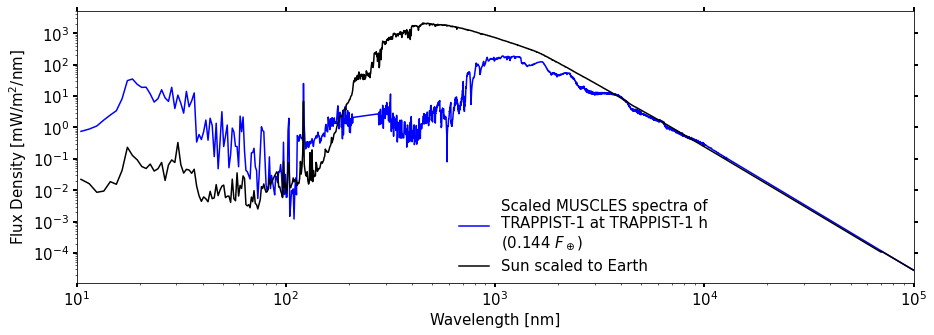

In [215]:
#Extend spectra using Raleigh Jeans Law
#add in functionality with PHOENIX for later
k = 1.381e-23
c = 299792458
T = pl['st_teff'].iloc[-1]
scaling = Initial_scaled_flux[max_wav-1]
RJL = 2*c*k*T/((model_wavelength[max_wav]*1e-9)**4)

IR_scaling = scaling/RJL
RJL_scaling = (IR_scaling)*(2*c*k*T/((model_wavelength*1e-9)**4))

Flux = np.append(Initial_scaled_flux, RJL_scaling[max_wav:])

RJL = 2*c*k*T/((new_wav_grid[-1]*1e-9)**4)

plt.figure(figsize = (15,5))
plt.plot(model_wavelength, Flux, color = 'b', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun scaled to Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.45,0.01), frameon = False, fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e5)

In [216]:
#after adding in IR through Rayleigh Jeans law, provide final scaling
final_scaling = flux_recieved_relative_to_Earth/(trapz(Flux, model_wavelength) / 1360000)
Final_scaled_flux = final_scaling*Flux

(10, 100000.0)

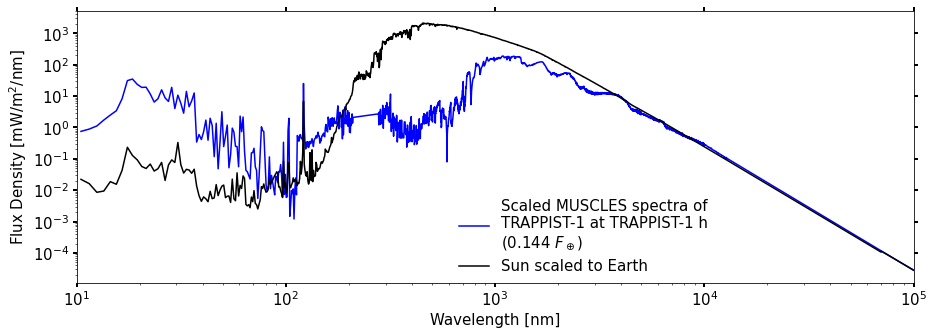

In [218]:
plt.figure(figsize = (15,5))
plt.plot(model_wavelength, Final_scaled_flux, color = 'b', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(flux_recieved_relative_to_Earth,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun scaled to Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.45,0.01), frameon = False, fontsize = 15)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e5)

In [219]:
#now write out the files
if (Climate_model_selection.value == 'WACCM' or Climate_model_selection.value == 'CAM'):
    ds.ssi.values[0] = Final_scaled_flux; ds.ssi.values[1] = Final_scaled_flux
    NewFile = 'TOA_Flux_at_'+Find_planets.value+'_for_'+Climate_model_selection.value+'.nc'
    NewFile = NewFile.replace(" ", "_")
    ds.to_netcdf(NewFile)
    print('File saved')
else:
    print('File not saved')

File saved


In [220]:
#examples for extra extra information about planet

In [221]:
#orbital period
period = pl['pl_orbper'].iloc[-1]
print(period)

18.772866


In [222]:
#orbital radius
radius = pl['pl_rade'].iloc[-1]
print(radius)

0.755


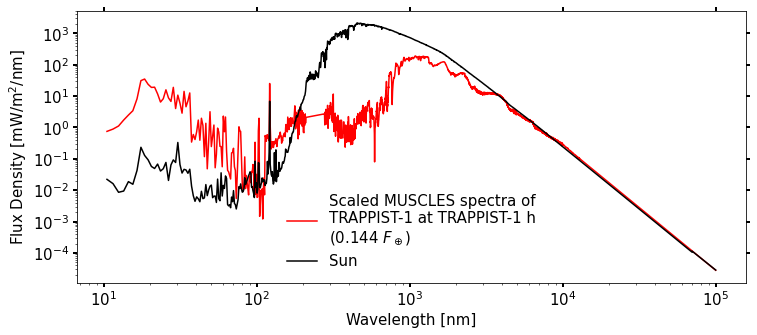

In [223]:
#rebinned spectra compared to Sun
plt.figure(figsize = (12,5))
plt.plot( model_wavelength, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(TSI_spectra/1360000,3))+' '+r'$F_\oplus$'+')')
plt.plot(model_wavelength,model_flux, color = 'k', label = 'Sun')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

(10, 100000.0)

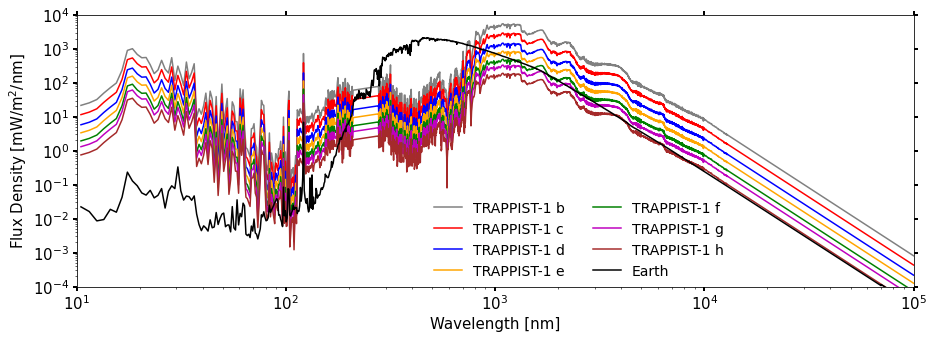

In [224]:
plt.figure(figsize = (15,5))
solar_file = 'TOA_Flux_at_TRAPPIST-1_b_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'grey', label = 'TRAPPIST-1 b')

solar_file = 'TOA_Flux_at_TRAPPIST-1_c_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'r', label = 'TRAPPIST-1 c')

solar_file = 'TOA_Flux_at_TRAPPIST-1_d_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'b', label = 'TRAPPIST-1 d')

solar_file = 'TOA_Flux_at_TRAPPIST-1_e_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'orange', label = 'TRAPPIST-1 e')


solar_file = 'TOA_Flux_at_TRAPPIST-1_f_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'g', label = 'TRAPPIST-1 f')


solar_file = 'TOA_Flux_at_TRAPPIST-1_g_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'm', label = 'TRAPPIST-1 g')


solar_file = 'TOA_Flux_at_TRAPPIST-1_h_for_WACCM.nc'#read in file
ds = xr.open_dataset(solar_file)#attach file to dataset
ssi = ds['ssi'].isel(time=0) #define dataset from file
TP1_flux = ssi.values #flux values
plt.plot(model_wavelength, TP1_flux, color = 'brown', label = 'TRAPPIST-1 h')

plt.plot(model_wavelength,model_flux, color = 'k', label = 'Earth')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength [nm]', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density [mW/m'+sup(2)+'/nm]', fontsize = 15); plt.yscale('log')
plt.legend(loc = (0.42,0.01), frameon = False, fontsize = 14, ncol = 2)
plt.ylim(1e-4,1e4)
plt.xlim(10,1e5)

SyntaxError: invalid decimal literal (427839947.py, line 1)